# **Time Series Forecasting - ARMA & ARDL**  

#### **We will focus on the analysis of Global Radiation measurements between 2017-2023.**
Global radiation refers to the total solar radiation received on a horizontal surface, encompassing both direct and diffuse solar radiation. This radiation is a key component of Earth's energy balance and plays a crucial role in various natural processes.
We selected a dataset spanning hourly measurements of global radiation recorded at the Haifa Technion station, covering the years from 2017 to 2023. 
Originally, the dataset provided measurements for each hour from 8:00 to 20:00. However, we opted to aggregate the data to compute daily averages, along with additional temporal information.
The dataset was sourced from the Israeli Meteorological Service website, under the governance of the Ministry of Transport and Road Safety. It comprises 2546 records and the average daily global radiation measured on each date (series index). 



In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ardl import ARDL
import statsmodels.api as sm
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

warnings.simplefilter(action='ignore', category=Warning)
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

palette = {'dark_navy': '#001253', 'mid_blue': '#3E6D9C', 'mid_orange': '#FD841F', 'light_blue': '#7FC7D9',
           'ham': '#8E3200', 'ham_light': '#A64B2A', 'mid_green': '#508D69',
           'dark_orange': '#E14D2A', 'dark_purple': '#2E073F', 'dark_green': '#1A5319'}
palette2 = {'green_teel': '#24A19C', 'lilach': "#9D65C9", 'peach': '#FE7E6D', 'banana': "#FFB961"}
palette3 = ['#FF9800', "#2C7865", "#124076", "#FFD0EC"]

In [6]:
def corr_plot(merged_df: pd.DataFrame, save_png=False, dir_path='images/'):
    exg_name = merged_df['type_exg'].iloc[0].capitalize()
    plt.figure(figsize=(6, 4))
    plt.scatter(merged_df['daily_avg_exg'], merged_df['daily_avg_end'], alpha=0.5, color=palette['dark_navy'],
                edgecolor=palette['dark_navy'], linewidth=1.5)
    correlation_matrix = merged_df[['daily_avg_end', 'daily_avg_exg']].corr()
    correlation_score = correlation_matrix.iloc[0, 1]

    end_max = merged_df['daily_avg_end'].max()
    exg_max = merged_df['daily_avg_exg'].max()

    plt.text(exg_max, end_max, f'Correlation Score: {correlation_score:.2f}', fontsize=10,
             bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'), ha='right', va='top')
    plt.xlabel(f'Exogenous Variable - {exg_name}')
    plt.ylabel('Global Radiation')
    plt.title(f'Global Radiation & {exg_name} - Correlation')
    if save_png:
        plt.savefig(f'{dir_path}/corr_plot.png')
    plt.show()


def acf_pacf(t_series: pd.Series, title=""):
    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(9, 3))

    plot_acf(t_series, lags=50, color='#001253', ax=axes[0])
    axes[0].set_title('Autocorrection Plot')
    axes[0].set_xlabel('Lag')
    axes[0].set_ylabel('Autocorrection')

    plot_pacf(t_series, lags=50, color='#001253', ax=axes[1])
    axes[1].set_title('Partial Autocorrection Plot')
    axes[1].set_xlabel('Lag')
    axes[1].set_ylabel('Partial Autocorrection')

    plt.suptitle(title)
    plt.tight_layout(rect=(0, 0, 1, 0.99))
    plt.show()


def create_time_series(df: pd.DataFrame) -> pd.Series:
    return df[['data']].iloc[:, 0]


def decompose_series(t_series: pd.Series):
    decomposition = seasonal_decompose(t_series, model='additive', two_sided=False, period=365)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    return trend, seasonal, residual


def assert_exog_endog(endog_var, exog_vars):
    common_index = exog_vars.index.intersection(endog_var.index)
    endog_var = endog_var.loc[common_index]
    exog_vars = exog_vars.loc[common_index]
    return endog_var, exog_vars


def df_starts_at(df, from_year=2018):
    date_threshold = pd.Timestamp(from_year, 1, 1)
    return df[df.index >= date_threshold]


def series_starts_at(series: pd.Series, from_year=2018) -> pd.Series:
    date_threshold = pd.Timestamp(from_year, 1, 1)
    return series[series.index >= date_threshold]


def plot_model_results(model, train, test, forecast, residuals):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3), width_ratios=[0.8, 0.2])
    axes[0].plot(train, color=palette['dark_navy'], label="Train")
    axes[0].plot(test, color=palette['mid_orange'], alpha=1, linewidth=1.5, label='Test - Actual')
    axes[0].plot(forecast, color=palette['dark_orange'], linewidth=1.5, label=f"Prediction")
    axes[0].legend()
    axes[0].set_title(f"ARIMA{model}")
    plt.ylabel("TA-125 (ILS)")
    plt.xlabel('Date')
    plt.grid()
    sm.qqplot(residuals, line='45', fit=True, ax=axes[1])
    axes[1].set_title('Q-Q Plot of Residuals')
    plt.tight_layout()
    plt.show()


def lags_plot(t_series: pd.Series, title=""):
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(24, 4), sharey=True)
    axes[0] = pd.plotting.lag_plot(t_series, lag=1, ax=axes[0], c=palette['mid_blue'], alpha=0.3)
    axes[0].axline(xy1=(0, 0), xy2=(1, 1), linestyle='--', c=palette['mid_green'], linewidth=2.5)
    axes[1] = pd.plotting.lag_plot(t_series, lag=14, ax=axes[1], c=palette['mid_blue'], alpha=0.3)
    axes[1].axline(xy1=(0, 0), xy2=(1, 1), linestyle='--', c=palette['mid_green'], linewidth=2.5)
    axes[2] = pd.plotting.lag_plot(t_series, lag=30, ax=axes[2], c=palette['mid_blue'], alpha=0.3)
    axes[2].axline(xy1=(0, 0), xy2=(1, 1), linestyle='--', c=palette['mid_green'], linewidth=2.5)
    axes[3] = pd.plotting.lag_plot(t_series, lag=60, ax=axes[3], c=palette['mid_blue'], alpha=0.3)
    axes[3].axline(xy1=(0, 0), xy2=(1, 1), linestyle='--', c=palette['mid_green'], linewidth=2.5)
    axes[4] = pd.plotting.lag_plot(t_series, lag=90, ax=axes[4], c=palette['mid_blue'], alpha=0.3)
    axes[4].axline(xy1=(0, 0), xy2=(1, 1), linestyle='--', c=palette['mid_green'], linewidth=2.5)
    plt.suptitle(f"{title} - Lag plot", fontweight='bold', fontsize=16)
    plt.show()

In [32]:
file_path = 'data/globalRad_sunDuration.csv'

data = pd.read_csv(file_path, parse_dates=['date'])
exog_name = data['type_exg'].iloc[0]
endog_data = data[['date', 'daily_avg_end']].set_index('date')
exog_data = data[['date', 'daily_avg_exg']].set_index('date')
df = data.rename({'date': 'ds', 'daily_avg_end': 'y'}, axis=1).copy()

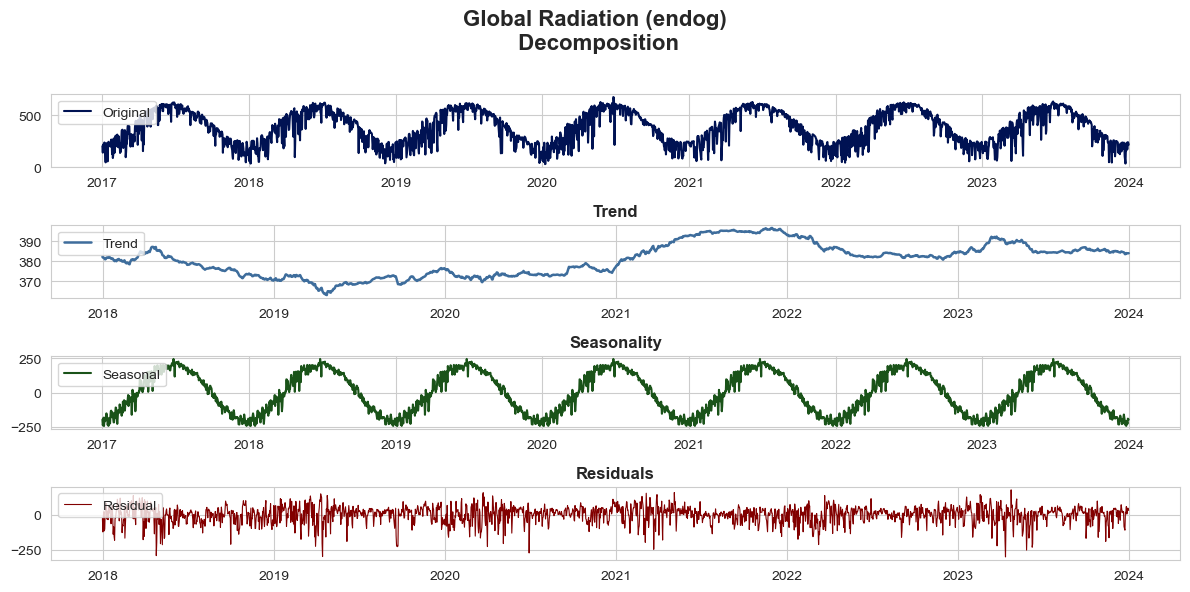

Dickey-Fuller test for stationary - Global Radiation (endog)


ADF Statistic: -2.7485778047420575
p-value: 0.06600275063669639


In [76]:
plot_decomposition(endog_data, title="Global Radiation (endog)\n")

#### By decomposing the Global Radiation time series, we can observe that seasonality manifests as fluctuations in global radiation levels throughout the year, with higher levels during certain seasons (e.g., Q3) and lower levels during others (e.g., Q1 and Q4). 
#### We can observe an overall trend by increasing radiation levels over the mentioned years. Also, we can observe from the boxplot (appendix) and residuals plot a discernible regularities or structures by short-term fluctuations outliers in Q2. 

#### While initially observing the data, we notice significant yearly seasonality. 
**This observation is not surprising as radiation depends on the sun which revolves around the earth based on a roughly estimated 365-days period.**
**Thus, the first model we considered was the SARIMA model, but the results of the fit weren’t very informative. Therefore, in this task, we decided to compare multiple models to gain a better understanding of the differences between them.**



#### The Dickey-Fuller test for stationary check indicates the  time-series data for the endogenous variable is 0.06 which is not significant for the base 0.05. 
Hence, we need to apply some invertible transformation.

In [84]:
deseas_endog = endog_data.diff(365).dropna()
deseas_exog = exog_data.diff(365).dropna()

# **Incorporating an Exogenous Variable**
Inclusion of exogenous variables enables the model to better capture the complex relationships and dependencies present in the data, resulting in more accurate predictions. 
Moreover, Exogenous variables that exhibit consistent trends or patterns over time are more likely to align closely with the fluctuations in global radiation. 
#### We checked 3 exogenous variables – **Rainfall, Temperature, and Sun duration.** 
The measures were available in the meteorological database and were all recorded at the Haifa Technion station, covering the years from 2017 to 2023.  
Preprocessing steps include converting dates to datetime format, calculating daily averages as aggregation, and handling with missing values for Sun duration (MCAR). 
A more comprehensive details in the appendix section. 


To determine the most suitable exogenous variable for inclusion we first calculate the correlation score between each exogenous variable (rainfall, sun duration, and temperature) and the target variable, global radiation. 
The correlation score helps assess the strength and direction of the relationship between each exogenous variable and global radiation. 
##### As demonstrated in the correlation plots in the appendix(1+2), the most correlated variable is **Sun duration, with 0.84 correlation score**

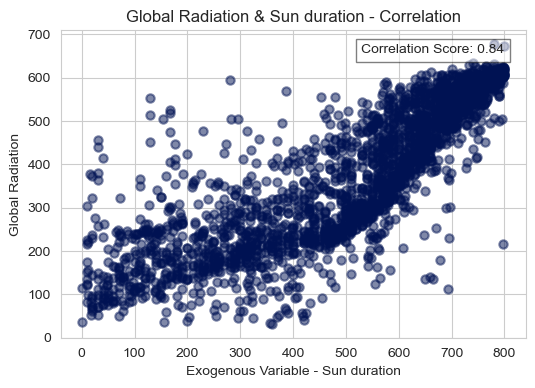

In [10]:
corr_plot(merged_df=data, dir_path='sub_folder_path', save_png=False)

### **Decomposition plots of Global Radiation & Sun Duration - differenced with d=365**

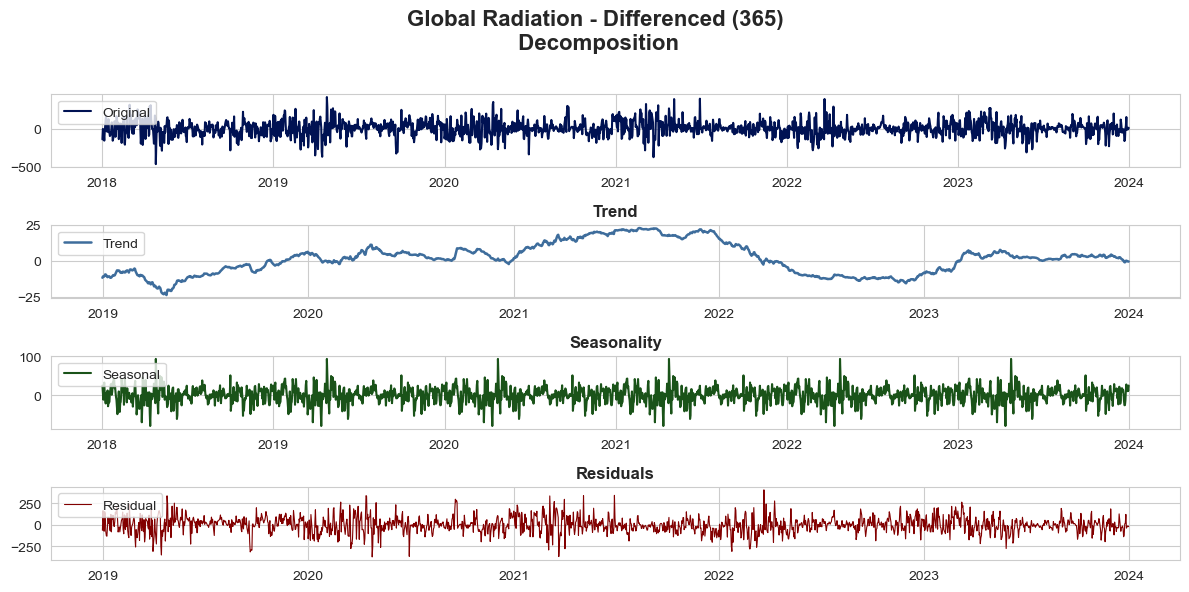

Dickey-Fuller test for stationary - Global Radiation - Differenced (365)


ADF Statistic: -10.579944104439367
p-value: 6.947280628653694e-19


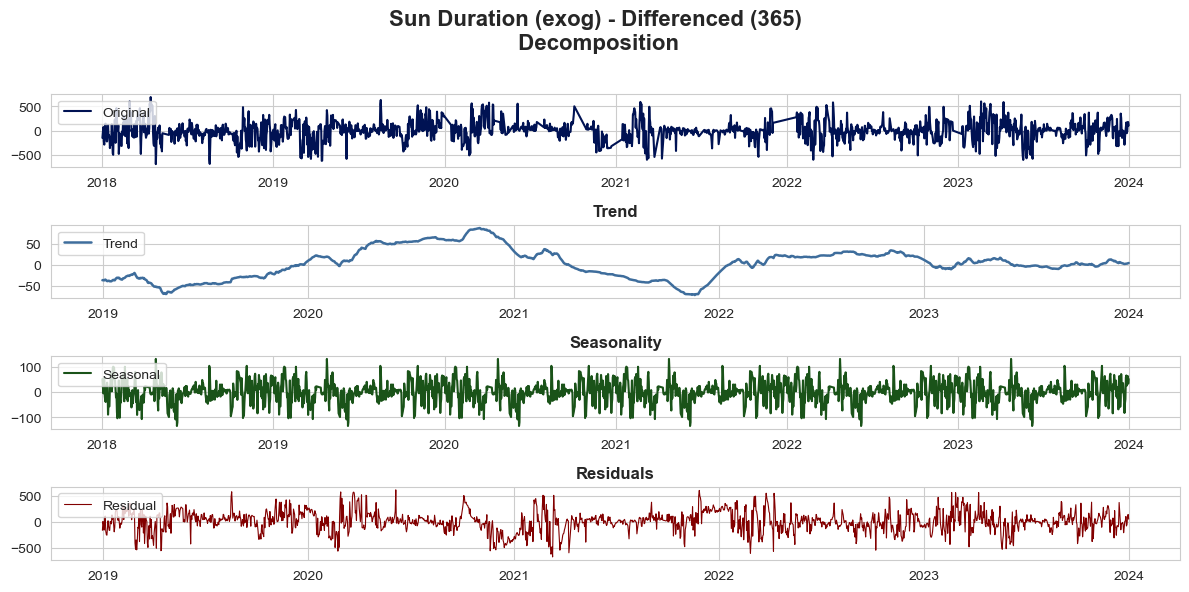

Dickey-Fuller test for stationary - Sun Duration (exog) - Differenced (365)


ADF Statistic: -7.603633469319639
p-value: 2.3534271771656012e-11


In [12]:
plot_decomposition(deseas_endog, title="Global Radiation - Differenced (365)\n")
plot_decomposition(deseas_exog, title="Sun Duration (exog) - Differenced (365)\n")

### The Dickey-Fuller test for stationary check indicates the transformed time-series for the endogenous variable is stationary with high significance, and for the exogenous variable time series as well.

### Modeling Univariate Time Series - Box–Jenkins approach 
1. Satisfactorily transform the data to obtain a stationary series. This step will usually mean taking first differences, logs, or both to obtain a series whose autocorrelation function eventually displays the
characteristic exponential decay of a stationary series.
2. Estimate the parameters of the resulting ARMA model, generally by nonlinear least squares (l1/l2).
3. Generate the set of residuals from the estimated model and verify that they satisfactorily resemble a white noise series. If not, re-specify the model and return to step 2.


The ACF is a useful device for describing a time-series process in much the same way that the moments are used to describe the distribution of a random variable. 
One of the characteristics of a stationary stochastic process is an autocorrelation function that either abruptly drops to zero at some finite lag or eventually tapers off to zero. 
The PACF measures the correlation between the time series and its lagged version, controlling for the correlations at all shorter lags. 


## Assumptions

Both models require some strong assumptions. we checked for the assumptions for models to exist:
- **Stationarity of time series** - The statistical properties of the series, such as mean and variance, should not change over time.
- **No multicollinearity** - The independent variables, including their lags, should not be highly correlated with each other, as this can lead to unstable coefficient estimates
- **Homoscedasticity** -  The variance of the error terms should be constant over time.

The raw serieses weren’t stationary, which required us to apply transformation for both series.
Based on the decomposition plot, ACF plot, and PACF plot, we decided to apply **differencing of 365 days**. 
This is a reasonable heuristic due to the seasonality of the variables.


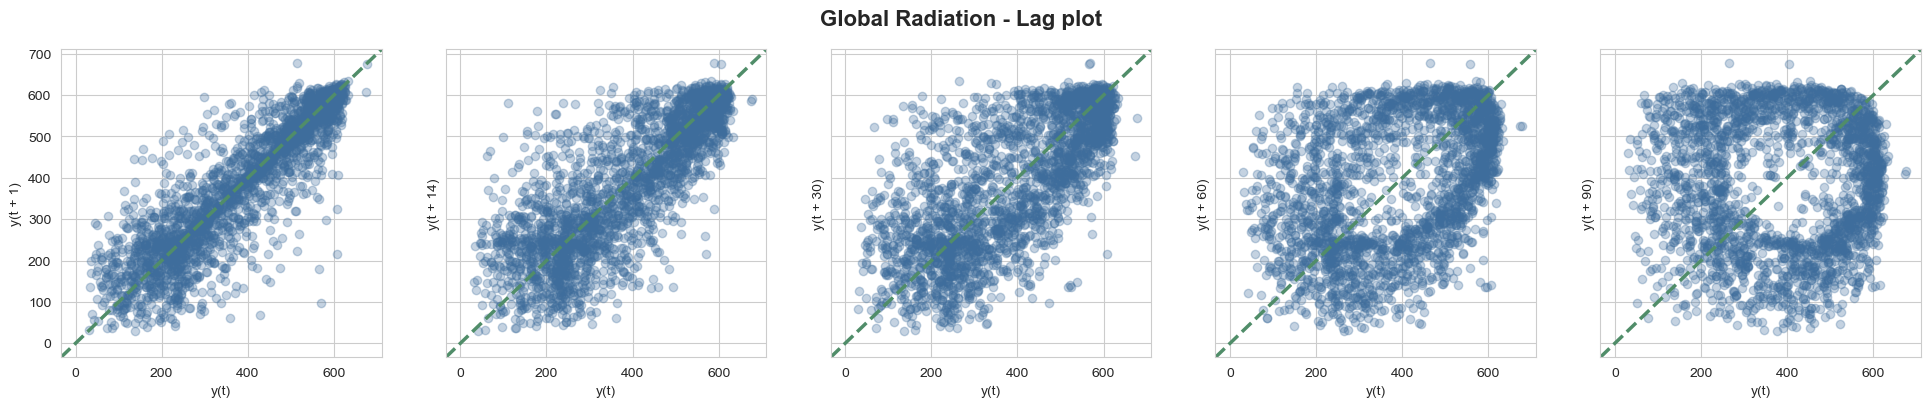

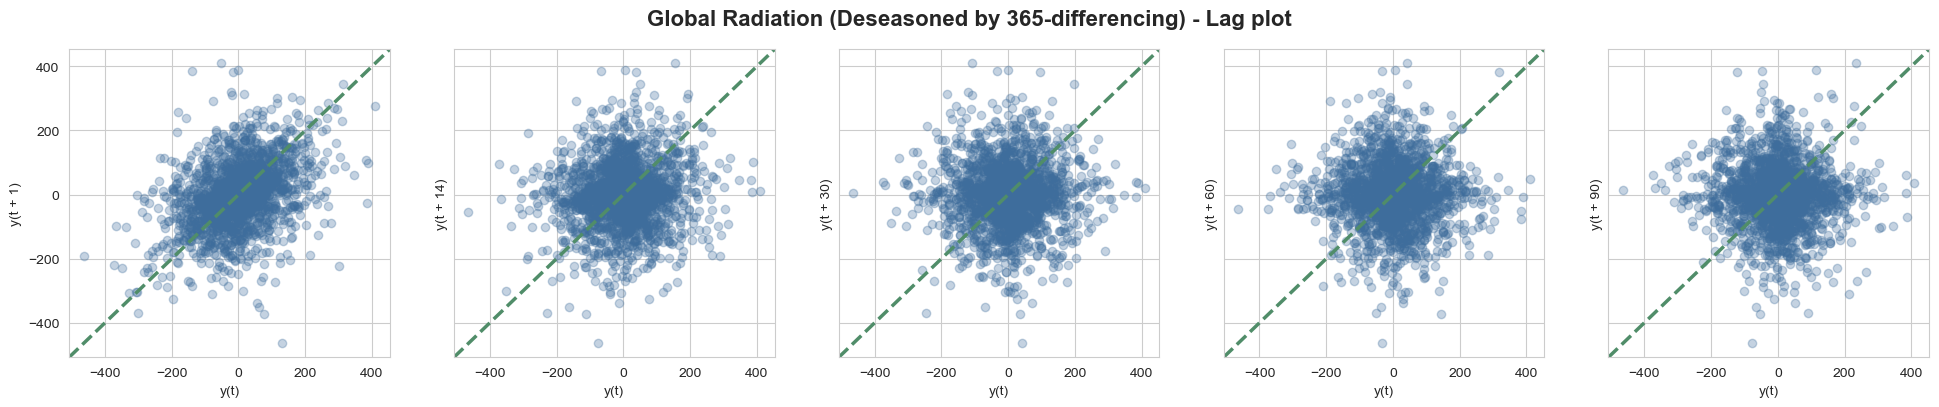

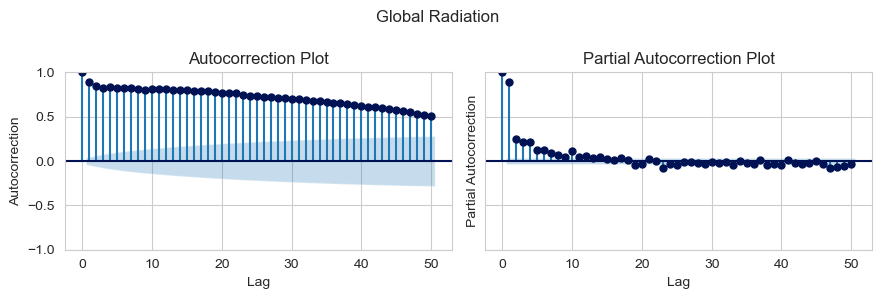

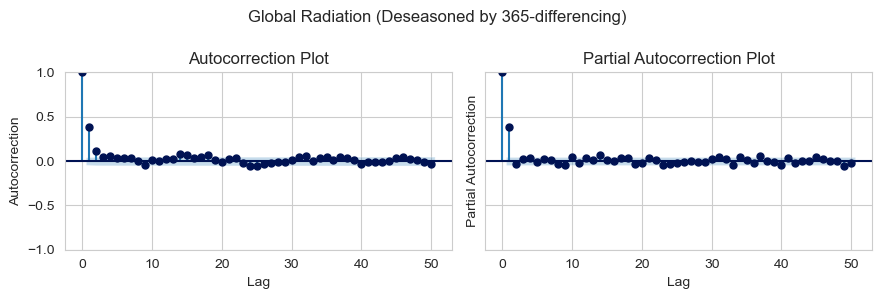

In [77]:
lags_plot(t_series=endog_data, title='Global Radiation')
lags_plot(t_series=deseas_endog, title='Global Radiation (Deseasoned by 365-differencing)')
acf_pacf(t_series=endog_data, title='Global Radiation')
acf_pacf(t_series=deseas_endog, title='Global Radiation (Deseasoned by 365-differencing)')

## Sun Duration

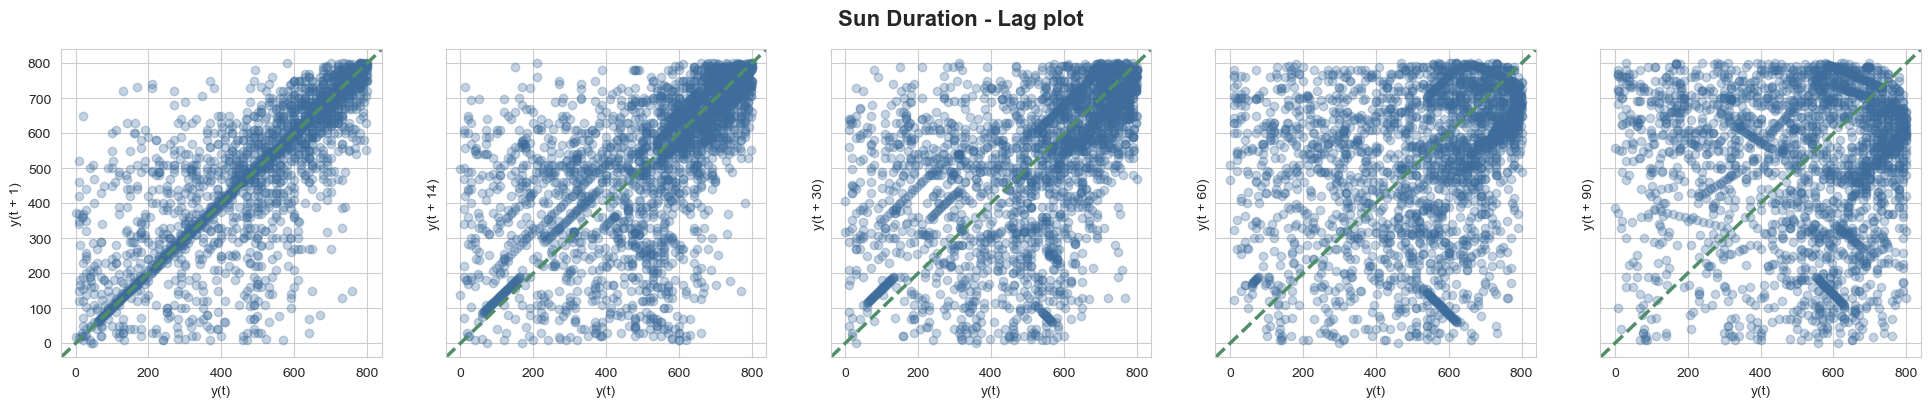

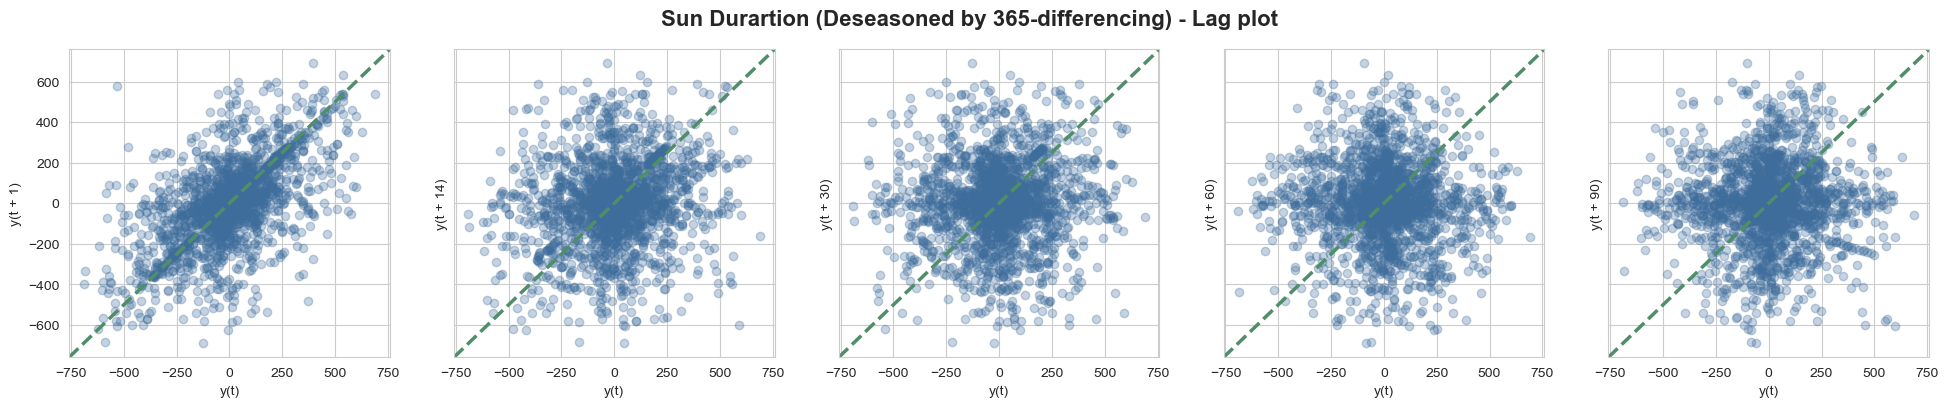

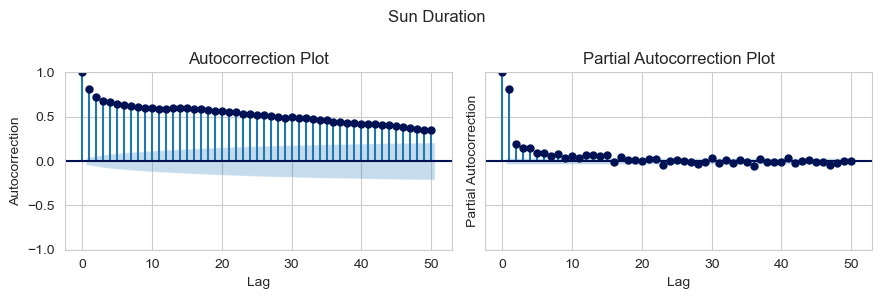

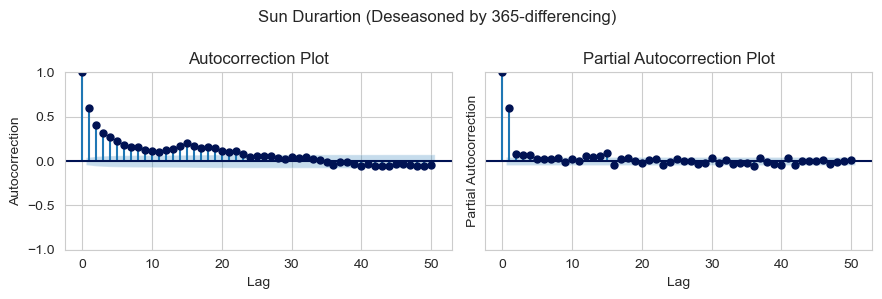

In [78]:
lags_plot(t_series=exog_data, title=exog_name)
lags_plot(t_series=deseas_exog, title='Sun Durartion (Deseasoned by 365-differencing)')
acf_pacf(t_series=exog_data, title=exog_name)
acf_pacf(t_series=deseas_exog, title='Sun Durartion (Deseasoned by 365-differencing)')

### The assumptions does hold - 

- **Stationarity of time series** - The statistical properties of the series, such as mean and variance, should not change over time.
- **No multicollinearity** - The independent variables, including their lags, should not be highly correlated with each other, as this can lead to unstable coefficient estimates
- **Homoscedasticity** -  The variance of the error terms should be constant over time

We can observe that for both variables the ACF plot drops to 0 in less of 5 lags, and for the exog var, after 25 lags (approximatly).

## Methods
We performed a grid search on model parameters for ARMA(p,q) and ADL(lags) by testing different parameters. 
A reasonable starting point for the parameters was chosen based on the ACF plots and lag plot of both the endogenous and exogenous variables. Since the model complexity was high, the AIC and BIC scores were relatively high. 
Therefore, **we decided to choose the best model based on the Mean Absolute Error (MAE) score**.

We also calculated the **RSE** and **RMSE** scores for the model, but due to fluctuations in the data, both RSE/RMSE might place more emphasis on shifts in the data. 
**In general, all models exhibited similar values for these scores, and we did not observe large differences between different model orders (ARMA) or lags (ADL).**

In [52]:
def plot_model_results(model, train, test, forecast, residuals, mae):
    fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(15, 6), sharex=True,
                              gridspec_kw={'hspace': 0.3, 'wspace': 0.1})
    ax1.scatter(test.index, test, color='r', facecolors='none')
    ax1.scatter(test.index, forecast, color='b', facecolors='none')
    plt.show()


def plot_arima_results(model, train, test, forecast, residuals, rmse, scorer="RMSE"):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3), width_ratios=[0.6, 0.2, 0.2])
    axes[0].plot(train.tail(30), color=palette['dark_navy'], linewidth=1.8, label="Train", linestyle='--')
    axes[0].plot(test, color=palette['dark_navy'], alpha=1, linewidth=2.5, label='Test - Actual')
    axes[0].plot(forecast, color=palette['dark_orange'], alpha=1, linewidth=1.5, label=f"Prediction")
    axes[0].scatter(test.index, test, color=palette['dark_navy'], alpha=0.375, edgecolor=palette['dark_navy'])
    #axes[0].scatter(forecast.index, forecast, color=palette['dark_orange'], alpha=0.375, )

    axes[0].text(test.tail(1).index, 200, f'{scorer}: {rmse:.4f}', fontsize=8,
                 bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'), ha='right', va='top')
    axes[0].legend()
    axes[0].set_title(f"ARIMA{model}")
    axes[0].set_ylabel("Global Radiation Change")
    axes[0].set_xlabel('Date')
    plt.grid()
    sm.qqplot(residuals, line='45', fit=True, ax=axes[1], color=palette['mid_blue'])
    axes[1].set_title('Q-Q Plot of Residuals')
    axes[2].scatter(residuals.index, residuals, color='#B3541E', edgecolor='#B3541E', alpha=0.5, linewidth=0.5,
                    label='Residuals')
    axes[2].axhline(y=0, xmin=0, xmax=1, linestyle='--', color=palette['dark_navy'])
    axes[2].set_xticks(ticks=residuals.index[::int(len(residuals) / 5)])  # Show every 5th index for clarity
    axes[2].set_xticklabels(residuals.index[::int(len(residuals) / 5)].strftime('%m/%y'), rotation=0, fontsize=8)
    axes[2].set_title("Residuals (-- Mean)")
    plt.tight_layout()
    plt.show()


def plot_adlr_results(model, train, test, forecast, residuals, rmse, scorer="RMSE"):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3), width_ratios=[0.6, 0.2, 0.2])
    axes[0].plot(train.tail(30), color=palette['dark_navy'], linewidth=1.8, label="Train", linestyle='--')
    axes[0].plot(test, color=palette['dark_navy'], alpha=1, linewidth=2.5, label='Test - Actual')
    axes[0].plot(forecast, color=palette['dark_orange'], alpha=1, linewidth=1.5, label=f"Prediction")
    axes[0].scatter(test.index, test, color=palette['dark_navy'], alpha=0.375, edgecolor=palette['dark_navy'])
    #axes[0].scatter(forecast.index, forecast, color=palette['dark_orange'], alpha=0.2, )

    axes[0].text(test.tail(1).index, 200, f'{scorer}: {rmse:.4f}', fontsize=8,
                 bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'), ha='right', va='top')
    axes[0].legend()
    axes[0].set_title(f"ADLR - {model}")
    axes[0].set_ylabel("Global Radiation Change")
    axes[0].set_xlabel('Date')
    plt.grid()
    sm.qqplot(residuals, line='45', fit=True, ax=axes[1])
    axes[1].set_title('Q-Q Plot of Residuals')
    axes[2].scatter(residuals.index, residuals, color='#B85C38', edgecolor='#B85C38', alpha=0.5, linewidth=0.8,
                    label='Residuals')
    axes[2].axhline(y=0, xmin=0, xmax=1, linestyle='--', color=palette['dark_navy'])
    axes[2].set_xticks(ticks=residuals.index[::int(len(residuals) / 5)])
    axes[2].set_xticklabels(residuals.index[::int(len(residuals) / 5)].strftime('%m/%y'), rotation=0, fontsize=8)
    axes[2].set_title("Residuals (-- Mean)")
    plt.tight_layout()
    plt.show()


def compare_forecasts(train, test, forecast_arma, forecast_ardl, arma_model, ardl_model, ardl_res, arima_res):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4), width_ratios=[0.2, 0.8])
    axes[1].plot(train.tail(30), color=palette['dark_navy'], linewidth=1.8, label="Train", linestyle='--')
    axes[1].plot(test, color=palette['dark_navy'], alpha=0.25, linewidth=2.7, label='Test - Actual')
    axes[1].scatter(test.index, test, color=palette['dark_navy'], alpha=0.375, )
    axes[1].plot(forecast_arma, color="#921A40", alpha=1, linewidth=1.8, label=f"{arma_model}")
    axes[1].plot(forecast_ardl, color='#0A6847', alpha=1, linewidth=1.8, label=f"{ardl_model}")
    axes[1].set_title("Predictions")
    axes[1].legend(loc='upper left')

    models = [ardl_res["Model"], arima_res["Model"]]
    metrics = ["MAE", "RMSE"]
    ardl_scores = [ardl_res['MAE'], ardl_res['RMSE']]
    arima_scores = [arima_res['MAE'], arima_res['RMSE']]
    maes = [arima_res['MAE'], ardl_res['MAE']]
    rmses = [arima_res['RMSE'], ardl_res['RMSE']]
    x = np.arange(len(metrics))
    width = 0.25

    bar1 = axes[0].bar(x - width / 2, arima_scores, width, color='#921A40', label=models[1])
    bar2 = axes[0].bar(x + width / 2, ardl_scores, width, color='#0A6847', label=models[0])

    axes[0].set_xlabel('Metrics')
    axes[0].set_ylabel('Scores')
    axes[0].set_title('Model Comparison')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(["MAE", "RMSE"])
    axes[0].legend()
    for bar in bar1:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom',
                     fontweight='bold')

    for bar in bar2:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom',
                     fontweight='bold')

    plt.tight_layout()
    plt.show()

In [24]:
def l2_error(y_true, y_pred):
    """
    Calculate MAPE given y_true and y_pred
    :param y_true: true valeus
    :param y_pred: predicted values
    :return: mean absolute percentage error
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.mean(np.square(y_true - y_pred)))


def l1_error(y_true, y_pred):
    """
    Calculate MAPE given y_true and y_pred
    :param y_true: true valeus
    :param y_pred: predicted values
    :return: mean absolute percentage error
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred))


def RSE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    RSE = np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_pred)) ** 2)
    return RSE

# **Models**

Test size was set to the last quarter of 2023, and was set to 90 days.
We used the MAE metric for choosing the best model, due to sensativity of RMSE and RSE for fluctuations in the data. 
> ##### Note - 
> In order to run the models and get all of the tested models plottings and summaries, set the parameter **"print_summary=True"** in the next cell.

In [99]:
print_summary = False

In [100]:
n = deseas_endog.size
test_size = 90
train_size = n - test_size

endog_train = deseas_endog.head(train_size)
endog_test = deseas_endog.tail(test_size + 1)

exog_train = deseas_exog.head(train_size)
exog_test = deseas_exog.tail(test_size + 1)
actual = endog_test
test_dates = deseas_endog.index

# **Autoregressive Moving Average - ARMA**

#### Checking for ARMA performance when encorparating the original exog series (before applying diff transformation) - 

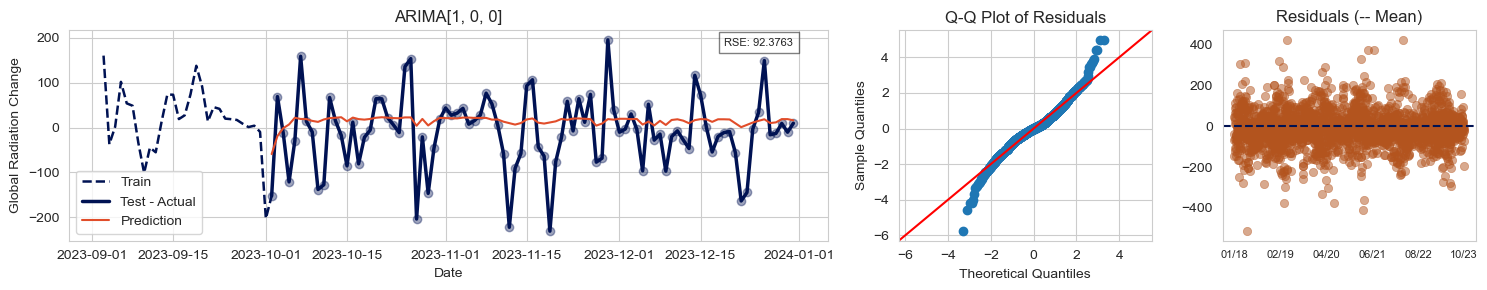

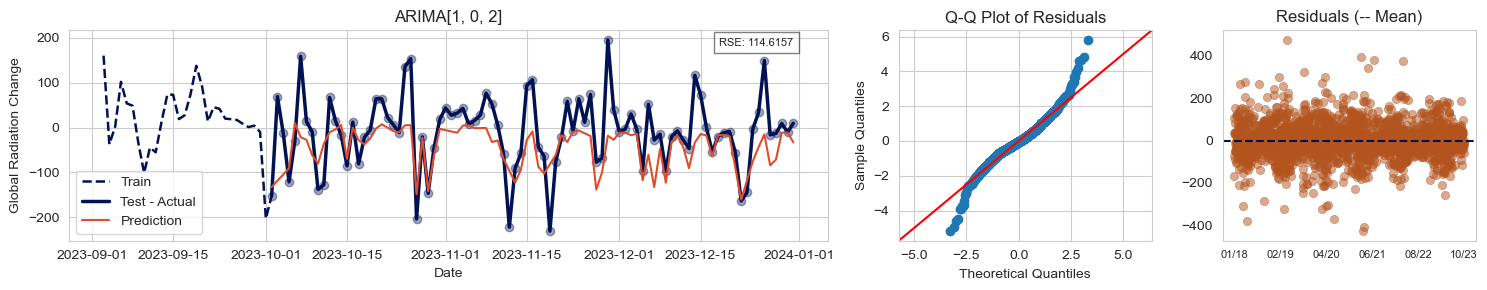

In [60]:
demo = [[1, 0, 0], [1, 0, 2]]
for model_order in demo:
    model = ARIMA(endog_train, exog=exog_data[365:].head(train_size), order=model_order, enforce_stationarity=False,
                  enforce_invertibility=False, trend='n', seasonal_order=(0, 0, 0, 365))
    result = model.fit()
    forecast = result.forecast(steps=test_size + 1, exog=exog_data[365:].tail(test_size + 1))
    forecast_index = actual.index
    forecast = pd.Series(forecast.values, index=forecast_index)
    residuals = result.resid
    if print_summary:
        print(result.summary())
    rmse = np.sqrt(result.mse)
    mae = result.mae
    rse = RSE(y_true=actual, y_pred=forecast)
    plot_arima_results(model_order, endog_train, endog_test, forecast, residuals, rse, scorer="RSE")

#### We can see poor performance on original exog data, comparing to the differenced exog data, which will be demonstated next - 

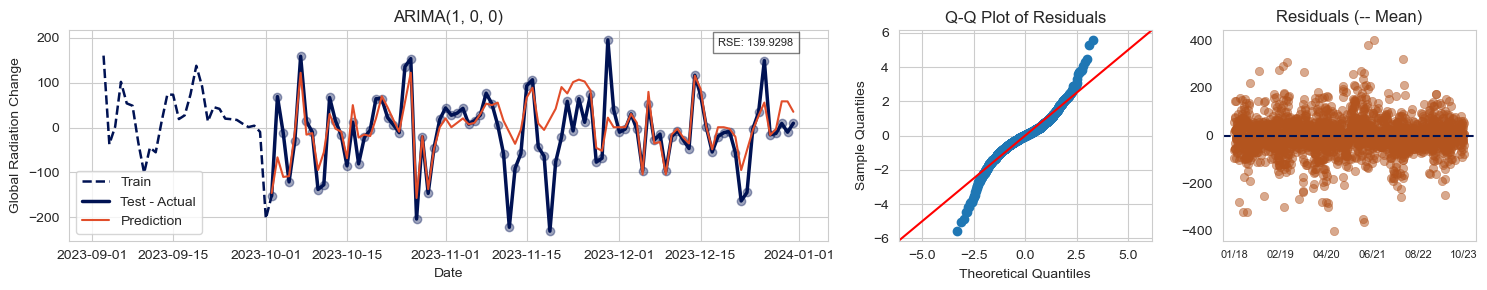

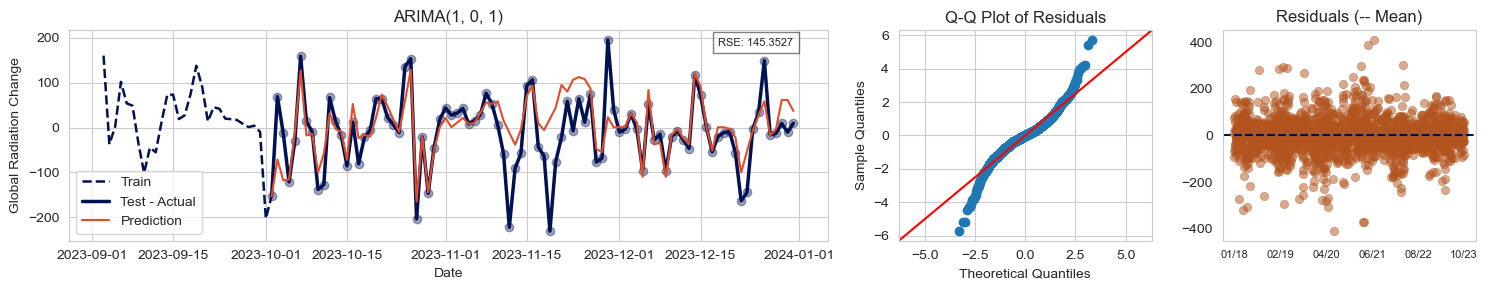

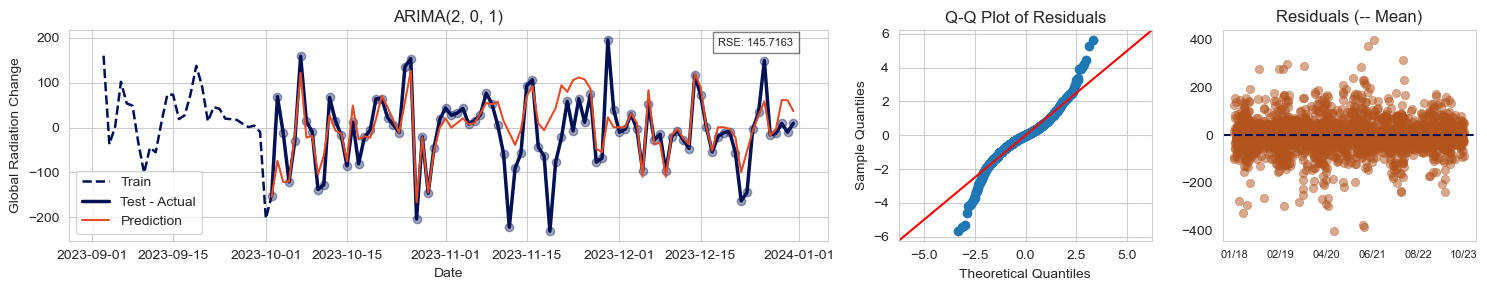

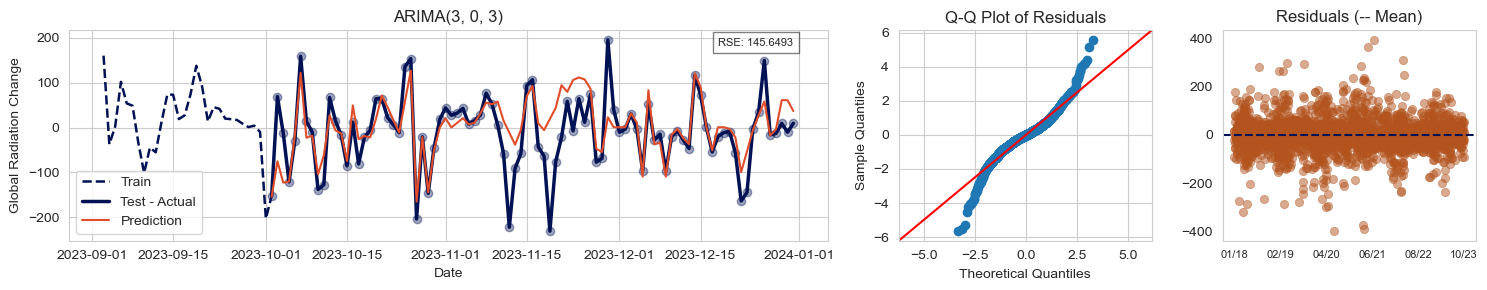

In [102]:
seasonal_order = (0, 0, 0, 365)
prev_model_orders = [(1, 0, 0), (0, 0, 1), (1, 0, 1), (2, 0, 1), (1, 0, 2), (2, 0, 2)]
model_orders = [(1, 0, 0), (2, 0, 1), (3, 0, 0), (0, 0, 3), (3, 0, 1), (1, 0, 3), (3, 0, 2), (2, 0, 3), (3, 0, 3)]
final_orders = [(1,0,0),(0,0,1),(1, 0, 1), (2, 0, 1),(1,0,2),(3,0,1),(3,0,3)]
arima_res = {"MAE": 0, "RMSE": 0}
best_rmse = 100
best_mae = 100
best_model_arma = (2, 0, 1)
best_forecast = []
for model_order in final_orders:
    model = ARIMA(endog_train, exog=exog_train, order=model_order, enforce_stationarity=False,
                  enforce_invertibility=False, trend='c', seasonal_order=seasonal_order)
    result = model.fit()
    forecast = result.forecast(steps=test_size + 1, exog=exog_test)
    forecast_index = actual.index
    forecast = pd.Series(forecast.values, index=forecast_index)
    residuals = result.resid
    rmse = np.sqrt(result.mse)
    mae = result.mae
    rse = RSE(y_true=actual, y_pred=forecast)
    if rmse < best_rmse:
        best_rmse = rmse
        best_mae = mae
        best_model_arma = model_order
        best_forecast = forecast
        plot_arima_results(model_order, endog_train, endog_test, forecast, residuals, rse, scorer="RSE")
        if print_summary:
            print(result.summary())
    else:
        if print_summary:
            print(result.summary())
            plot_arima_results(model_order, endog_train, endog_test, forecast, residuals, rse, scorer="RSE")
arima_res = {"Model": f"ARMA {best_model_arma}", "MAE": best_mae, "RMSE": best_rmse, "pred": best_forecast}
if print_summary:
    print(f"ARIMA {best_model_arma}\n\tLowest RMSE {best_rmse:.4f}\n\tLowest MAE {best_mae:4f}")

### Overall, ARMA predictions provided a good fit with the differenced series. 
We tried grid search by testing p,q∈{0,1,2,3}. Each of the params performed quite a good fit. 
The QQ-plot of residuals appears to be close to normality, and the residuals exhibit homoscedasticity, though with high variance. 
The variance of the error terms remains constant over time, ensuring that the model assumptions hold.

# **Autoregressive Distributed Lag (ADL)**

#### In the ADL model, we first check its performance without an exogenous variable.
The model fit was not accurate, and despite trying different lags, all model predictions were flat. 
However, the QQ-plot for residuals and the homoscedasticity check indicated that the model assumptions does align. 


                              ARDL Model Results                              
Dep. Variable:          daily_avg_end   No. Observations:                 2101
Model:                Seas. ARDL(60,)   Log Likelihood              -12043.000
Method:               Conditional MLE   S.D. of innovations             88.376
Date:                Thu, 10 Oct 2024   AIC                          24108.000
Time:                        16:39:19   BIC                          24169.833
Sample:                    03-02-2018   HQIC                         24130.680
                         - 10-02-2023                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
s(1,7)               -2.2575      5.186     -0.435      0.663     -12.428       7.913
s(2,7)                6.2529      5.194      1.204      0.229      -3.932      16.438
s(3,7)               -7.

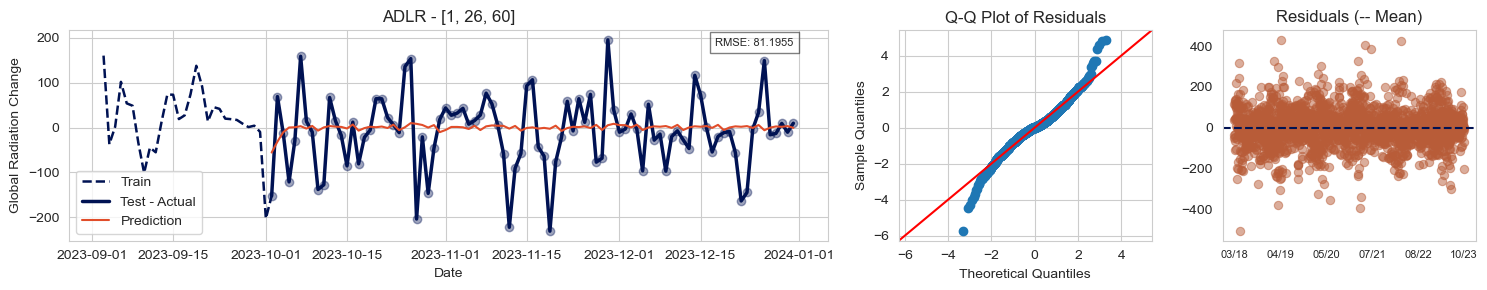

In [95]:
lags_list = [1, 26, 60]
exog_train, exog_test = None, None
model = ARDL(endog=endog_train, exog=exog_train, lags=lags_list, trend='n', seasonal=True)
result = model.fit()
forecast = result.forecast(steps=test_size + 1, exog=exog_test)
forecast_index = actual.index
forecast = pd.Series(forecast.values, index=forecast_index)
residuals = result.resid
if print_summary:
    print(result.summary())
rmse = l2_error(actual, forecast)
plot_adlr_results(lags_list, endog_train, actual, forecast, residuals, rmse)

### Incorparating an exog variable

In [103]:
n = deseas_endog.size
test_size = 90
train_size = n - test_size

endog_train = deseas_endog.head(train_size)
endog_test = deseas_endog.tail(test_size + 1)

exog_train = deseas_exog.head(train_size)
exog_test = deseas_exog.tail(test_size + 1)
actual = endog_test
test_dates = deseas_endog.index

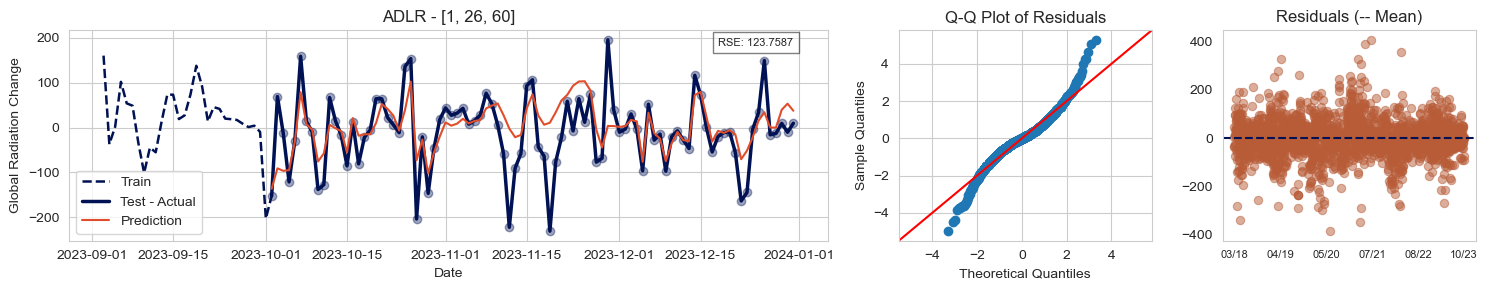

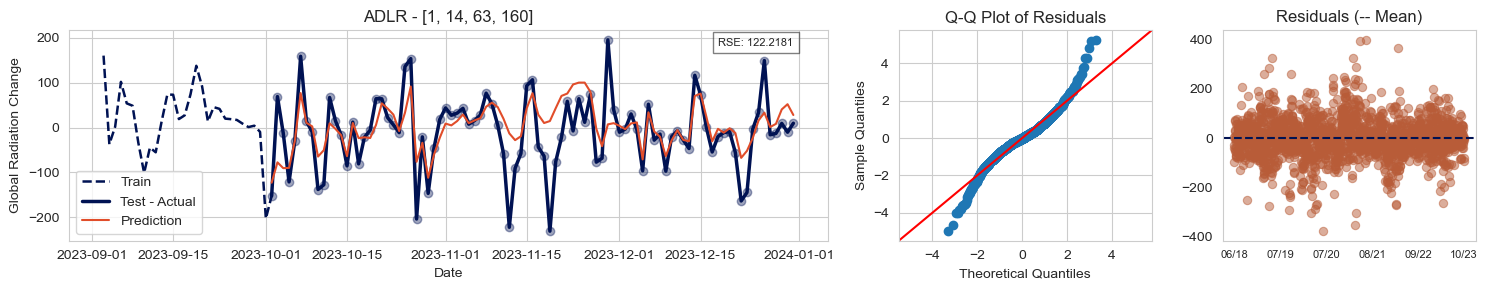

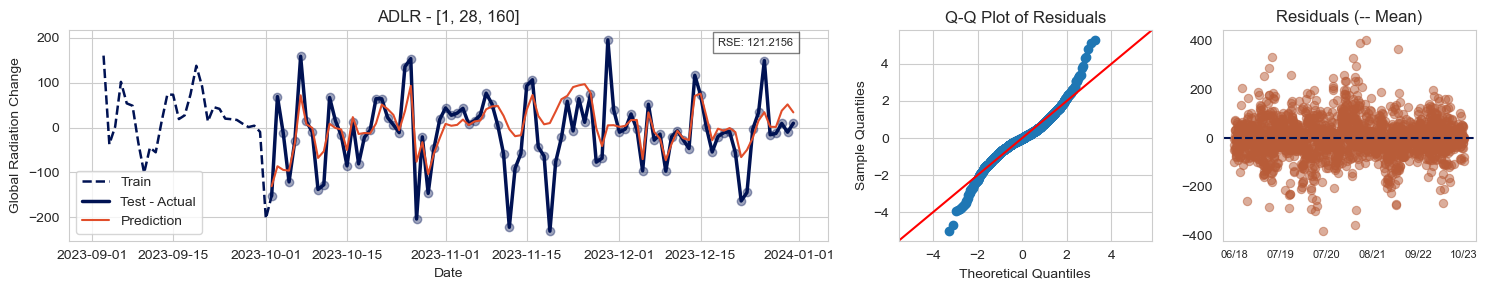

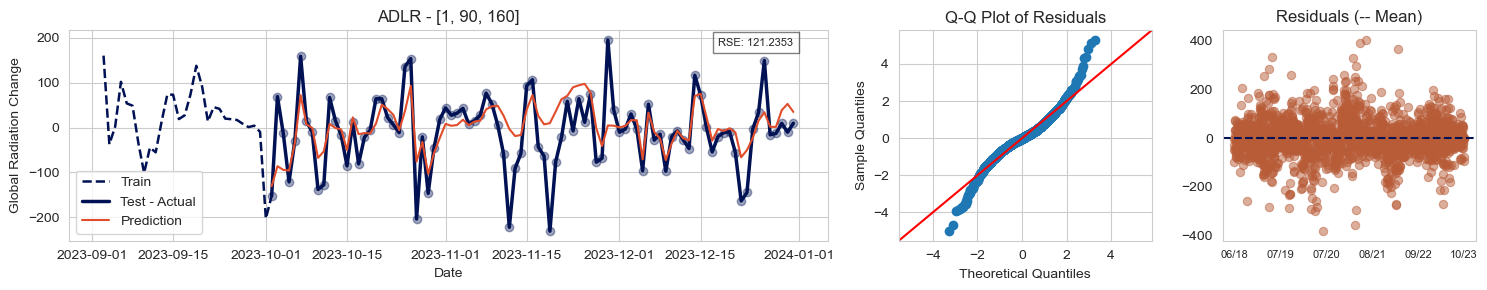

In [104]:
ardl_res = {"MAE": 0, "RMSE": 0}

best_mae = 200
best_rmse = 200
lags = [[1, 26, 60], [1, 14, 63, 160], [1, 28, 160], [1, 90], [1, 25], [1, 28, 63, 90, 160], [1, 90, 160]]
best_model_ardl = [1]
best_forecast = []
for lag in lags:
    actual = endog_test
    model = ARDL(endog=endog_train, exog=exog_train, lags=lag, trend='n', seasonal=True)
    result = model.fit()
    forecast = result.forecast(steps=test_size + 1, exog=exog_test)
    forecast_index = actual.index
    forecast = pd.Series(forecast.values, index=forecast_index)
    residuals = result.resid
    if print_summary:
        print(result.summary())
    mae = l1_error(actual, forecast)
    rmse = l2_error(actual, forecast)
    rse = RSE(y_true=actual, y_pred=forecast)
    if mae < best_mae:
        best_mae = mae
        best_rmse = rmse
        best_model_ardl = lag
        best_forecast = forecast
        plot_adlr_results(lag, endog_train, actual, forecast, residuals, rse, scorer="RSE")
    else:
        if print_summary:
            plot_adlr_results(lag, endog_train, actual, forecast, residuals, rse, scorer="RSE")
ardl_res = {"Model": f"ARDL {best_model_ardl}", "MAE": best_mae, "RMSE": best_rmse, 'pred': best_forecast}
if print_summary:
    print(f"ARDL best lags{best_model_ardl}\n\tLowest RMSE {best_rmse:4f}\n\tLowest MAE {best_mae:f}")

#### After incorporating the Sun duration variable as exogenous variable, the ADL model performance showed much better fit to the data. 

# **Models Comparison**
#### We can observe that ARDL has both MAE & RMSE lower then ARMA, but ARMA seems to have a better capture of the flactuations. 
##### This can be due to different model structure:
- **ARDL** models handle long-term relationships between the variables and lags of both the dependent and independent variables. ARDL might be better at forecasting the average trend or levels of the series but could smooth out short-term fluctuations due to its focus on both explanatory variables and lagged terms. Also, as discussed on class, ADRL is a good solution for time series that do not perform instansious changes.
- **ARMA** models rely solely on the lags of the dependent variable (AR component) and past errors (MA component). While ARMA might produce higher MAE/RMSE, it can capture short-term dependencies and fluctuations more effectively. The MA part of the ARMA model adjusts based on recent shocks in the data, which can help in fitting rapid changes or short-term volatility better than ARDL.

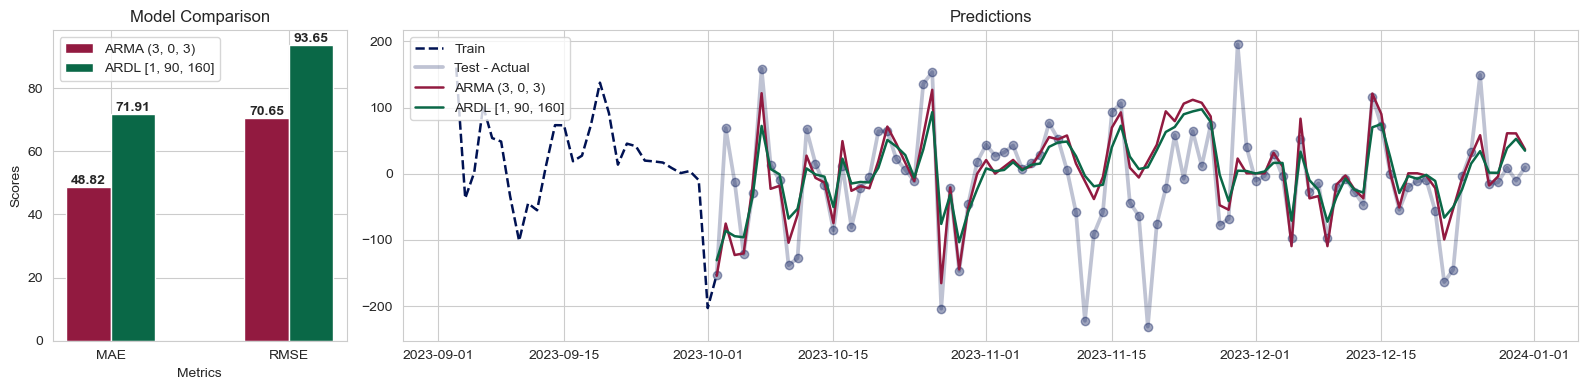

In [105]:
compare_forecasts(endog_train, actual, forecast_arma=arima_res['pred'], forecast_ardl=ardl_res['pred'],
                  arma_model=arima_res["Model"], ardl_model=ardl_res["Model"], arima_res=arima_res, ardl_res=ardl_res)